In [8]:
import pathlib
import os

Clone Tensorflow Object Detection API github

In [9]:
cwd = os.getcwd()
cwd

'/home/thangthewinner/git/git_personal/Clothes_Search_Engine_origin'

In [10]:
if "models" in pathlib.Path(cwd).parts:
    while "models" in pathlib.Path(cwd).parts:
        os.chdir('..')
elif not pathlib.Path("models").exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Install Object Detection API

In [11]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /home/thangthewinner/git/git_personal/Clothes_Search_Engine_origin/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached avro_python3-1.10.2-py3-none-any.whl
  Using cached apache_beam-2.60.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached lxml-5.3.0-cp38-cp38-manylinux_2_28_x86_64.whl.metadata (3.8 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.7 kB)
  Using cached Cython-3.0.11-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached contextlib2-21.6.0-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached pycocotools-2.0.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached lvis-0.5.3-py3-none-any.whl.metadata (856 bytes)
  Using cached scipy-1.10.1-cp38-cp38-m

Clone the reference github project if you want to see the first idea of this project

In [5]:
"""
if "fashion-visual-search" in pathlib.Path.cwd().parts:
    while "fashion-visual-search" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('fashion-visual-search').exists():
    !git clone https://github.com/TanThinNguyen/fashion-visual-search.git
"""

'\nif "fashion-visual-search" in pathlib.Path.cwd().parts:\n    while "fashion-visual-search" in pathlib.Path.cwd().parts:\n        os.chdir(\'..\')\nelif not pathlib.Path(\'fashion-visual-search\').exists():\n    !git clone https://github.com/TanThinNguyen/fashion-visual-search.git\n'

Import packages

In [6]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import faiss

2024-11-24 15:52:32.086404: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 15:52:32.087887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 15:52:32.118832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 15:52:32.119678: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 15:52:32.941589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [7]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

### Detection Preparation

Download saved detection model in to the main folder

In [8]:
!wget "https://drive.google.com/uc?export=download&id=1K2Gt346QIyrOEkzwAM0rQBCj1Fa3Lf-p"

--2024-11-24 15:52:34--  https://drive.google.com/uc?export=download&id=1K2Gt346QIyrOEkzwAM0rQBCj1Fa3Lf-p
Resolving drive.google.com (drive.google.com)... 142.250.196.238, 2404:6800:4005:819::200e
Connecting to drive.google.com (drive.google.com)|142.250.196.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1K2Gt346QIyrOEkzwAM0rQBCj1Fa3Lf-p&export=download [following]
--2024-11-24 15:52:35--  https://drive.usercontent.google.com/download?id=1K2Gt346QIyrOEkzwAM0rQBCj1Fa3Lf-p&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.198.193, 2404:6800:4005:825::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.198.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2431 (2,4K) [text/html]
Saving to: ‘uc?export=download&id=1K2Gt346QIyrOEkzwAM0rQBCj1Fa3Lf-p.2’

uc?export=download& 100%[===================

Download model from url link, extract and paste to root folder (clothes_search_app)

Labels map

In [9]:
# Label Map
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'fashion-visual-search/data/deepfashion_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Load detection model

In [10]:
model_name = 'faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8'
detection_model = tf.saved_model.load("inference_graph/saved_model/")

2024-11-24 15:52:36.128779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 15:52:36.129097: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Get the FAISS index

Download and save faiss_index to static/ so that you don't need to embedding and save faiss_index (it take a long time).

In [1]:
!wget "https://drive.google.com/file/d/1ZJXwdYzddPHEC8zi0SD17JzHIRmPEcXR/view"

--2024-12-22 11:41:35--  https://drive.google.com/file/d/1ZJXwdYzddPHEC8zi0SD17JzHIRmPEcXR/view
Resolving drive.google.com (drive.google.com)... 142.250.71.142, 2404:6800:4005:806::200e
Connecting to drive.google.com (drive.google.com)|142.250.71.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view’

view                    [ <=>                ]  91,42K   508KB/s    in 0,2s    

2024-12-22 11:41:36 (508 KB/s) - ‘view’ saved [93616]



### Embedding images

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import cv2
import os
import time
from keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [12]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D

In [13]:
# Using ResNet50 to extract features
img_width, img_height, channel = (224, 224, 3)

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

In [14]:
data_path = "static/img/"
embeddings_path = "static/embeddings/"

os.makedirs(embeddings_path, exist_ok=True)

img_path = pathlib.Path(data_path)

Because this data is too big so I just working on first 300 folder.

In [15]:
# Extract first 300 folder names
folder_names = [folder for folder in img_path.iterdir() if folder.is_dir()]
folder_names = sorted(folder_names, key=lambda folder:folder.name)
folder_names = folder_names[:300]
folder_names

[PosixPath('static/img/1981_Graphic_Ringer_Tee'),
 PosixPath('static/img/2-in-1_Space_Dye_Athletic_Tank'),
 PosixPath('static/img/25_Mesh-Paneled_Jersey_Dress'),
 PosixPath('static/img/36_Plaid_Shirt_Dress'),
 PosixPath('static/img/ACDC_Graphic_Tee'),
 PosixPath('static/img/ASPCA_Happy_Face_Hoodie'),
 PosixPath('static/img/ASPCA_Urban_Myth_Tee'),
 PosixPath('static/img/Above_Average_Linen_Tee'),
 PosixPath('static/img/Abstract-Embroidered_Glitter_Shorts'),
 PosixPath('static/img/Abstract-Geo_Print_Mini_Skirt'),
 PosixPath('static/img/Abstract-Paneled_Running_Shorts'),
 PosixPath('static/img/Abstract-Patterned_Blouse'),
 PosixPath('static/img/Abstract-Plaid_Ruffled_Bell_Sleeve_Top'),
 PosixPath('static/img/Abstract-Printed_Capri_Leggings'),
 PosixPath('static/img/Abstract-Quilted_Drawstring_Hoodie'),
 PosixPath('static/img/Abstract-Stripe_Fuzzy_Sweater'),
 PosixPath('static/img/Abstract-Striped_Ladder-Back_Dress'),
 PosixPath('static/img/Abstract-Trimmed_Knit_Tank'),
 PosixPath('static/

In [16]:
def run_inference_for_single_image(model, image_path):
    """Run inference for a single image using the object detection model."""
    image = np.array(Image.open(image_path))
    input_tensor = tf.convert_to_tensor(image)[tf.newaxis, ...]  # Add batch dimension
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # Process outputs
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle mask models (if present)
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        output_dict['detection_masks_reframed'] = tf.cast(detection_masks_reframed > 0.5, tf.uint8).numpy()

    return output_dict

In [19]:
def detect_clothes(model, image_path):
    """Detect clothing in an image and crop it based on bounding box."""
    output_dict = run_inference_for_single_image(model, image_path)
    image = np.array(Image.open(image_path))

    # Filter bounding boxes with sufficient confidence (threshold 0.5)
    scores = output_dict['detection_scores']
    if len(scores) == 0 or max(scores) < 0.5:
        raise ValueError("No bounding box with sufficient confidence found.")

    # Get the highest confidence bounding box
    highest_score_idx = np.argmax(scores)
    box = output_dict['detection_boxes'][highest_score_idx]
    x1, y1, x2, y2 = (
        int(box[1] * image.shape[1]),
        int(box[0] * image.shape[0]),
        int(box[3] * image.shape[1]),
        int(box[2] * image.shape[0]),
    )
    # Crop the detected region (clothing)
    return image[y1:y2, x1:x2]

In [18]:
def extract_features(img_array, model, target_size=(224, 224)):
    """Extract features from the cropped image and normalize."""
    # Resize the image to the required size
    resized_img = tf.image.resize(img_array, target_size)
    resized_img = np.array(resized_img)  # Convert Tensor to NumPy array
    
    # Ensure the image has the correct shape
    resized_img = np.expand_dims(resized_img, axis=0)  # Add batch dimension
    resized_img = preprocess_input(resized_img)  # Preprocess input as per ResNet50's requirements
    
    # Predict features
    features = model.predict(resized_img)
    features = features.flatten()
    
    return features

The following code below is embedding images. It require a good CPU and GPU, it will take a long time.

In [ ]:
"""
batch_size = 500
num_batches = len(folder_names) // batch_size + 1 # Number of batches required
no_object_detected_count = 0
folder_count = 0

for batch_idx in range(num_batches):
    batch_folders = folder_names[batch_idx * batch_size:(batch_idx + 1) * batch_size]
    for folder in batch_folders:
        folder_name = folder.name
        folder_count += 1
        print(f"Processing folder {folder_count}: {folder_name}")
        img_folder = pathlib.Path(folder)

        for img in img_folder.iterdir():
            img_name = img.name.split(".")[0]
            img_path = str(img)
            
            try:
                cropped_img = detect_clothes(detection_model, img_path)
                # Extract features from the cropped image (passed as a numpy array)
                features = extract_features(cropped_img, base_model)
                # Save the features with the original image name
                np.save(os.path.join(embeddings_path, f"{folder_name}_{img_name}.npy"), features)
            except ValueError:
                no_object_detected_count += 1

print(f"Number of images with no object detected: {no_object_detected_count}")
"""

Processing folder 1: 1981_Graphic_Ringer_Tee
1/1 [==============================] - 0s 49ms/step
Processing folder 2: 2-in-1_Space_Dye_Athletic_Tank
1/1 [==============================] - 0s 46ms/step
Processing folder 3: 25_Mesh-Paneled_Jersey_Dress
1/1 [==============================] - 0s 46ms/step
Processing folder 4: 36_Plaid_Shirt_Dress
1/1 [==============================] - 0s 46ms/step
Processing folder 5: ACDC_Graphic_Tee
1/1 [==============================] - 0s 45ms/step
Processing folder 6: ASPCA_Happy_Face_Hoodie
1/1 [==============================] - 0s 44ms/step
Processing folder 7: ASPCA_Urban_Myth_Tee
1/1 [==============================] - 0s 49ms/step
Processing folder 8: Above_Average_Linen_Tee
1/1 [==============================] - 0s 47ms/step
Processing folder 9: Abstract-Embroidered_Glitter_Shorts
1/1 [==============================] - 0s 45ms/step
Processing folder 10: Abstract-Geo_Print_Mini_Skirt
1/1 [==============================] - 0s 48ms/step
Processing f

The following code below is used to save all the embeddings to faiss index. This is done to speed up the process of searching for similar images.

In [ ]:
"""
index_path = "static/faiss_index.index"
file_names_path = "static/file_names.npy"
batch_size = 1000
embedding_dim = 100352  # Kích thước embedding
index = faiss.IndexFlatIP(embedding_dim)  # Sử dụng Inner Product (IP)

file_names = []
batch = []

embeddings_path = pathlib.Path(embeddings_path)
for file_idx, file in enumerate(embeddings_path.iterdir()):
    if file.is_file():
        embedding = np.load(file).astype(np.float32)
        # Chuẩn hóa vector trước khi thêm vào index
        embedding = embedding / np.linalg.norm(embedding)
        batch.append(embedding)
        file_names.append(file.name)

        if (file_idx + 1) % batch_size == 0:
            batch = np.array(batch, dtype=np.float32)
            index.add(batch)
            batch = []

if batch:
    batch = np.array(batch, dtype=np.float32)
    index.add(batch)

faiss.write_index(index, index_path)
np.save(file_names_path, file_names)
"""

In [ ]:
score_threshold = 0.9

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=4,
        min_score_thresh=score_threshold)

    #display(Image.fromarray(image_np))
    return image_np, output_dict

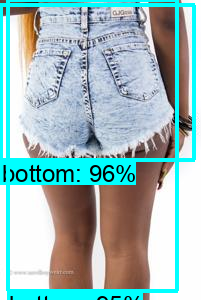

In [ ]:
img_path = "static/img/Acid_Wash_Denim_Cutoffs/img_00000009.jpg"
image_np, output_dict = show_inference(detection_model, img_path)
test_img = plt.imread(img_path)

display(Image.fromarray(image_np))

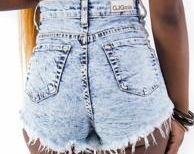

In [ ]:
detection_scores = output_dict["detection_scores"]
detection_boxes = output_dict["detection_boxes"]
detection_classes = output_dict["detection_classes"]

x1 = int(test_img.shape[1] * detection_boxes[0, 1])
y1 = int(test_img.shape[0] * detection_boxes[0, 0])
x2 = int(test_img.shape[1] * detection_boxes[0, 3])
y2 = int(test_img.shape[0] * detection_boxes[0, 2])
cropped = test_img[y1:y2, x1:x2, :]
display(Image.fromarray(cropped))